## Dogs v Cats

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
import skimage

In [7]:
PATH = "data/DogVsCats/"
sz = 224
arch = resnet34
bs = 64

In [8]:
m = arch(True)

In [9]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [10]:
# fastai 将pretrained的模型的上述架构的最后的全连接层给删除了。 参考下面的做法
# 因为用于判断猫还是狗，所以输出一个就行了。
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [12]:
learn = ConvLearner.from_model_data(m, data)

In [13]:
learn.freeze_to(-4)

In [14]:
m[-1].trainable

True

In [15]:
m[-4].trainable

True

In [16]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.20032    0.102889   0.9905    



[array([0.10289]), 0.9905]

In [17]:
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.115988   0.089331   0.9915    



[array([0.08933]), 0.9915]

## Class Activation Maps (CAM)

显示图像中关键部分

In [39]:
class SaveFeatures():
    features=None
    # hook是PyTorch独有的回调方式
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [40]:
x,y = next(iter(data.val_dl))

In [41]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

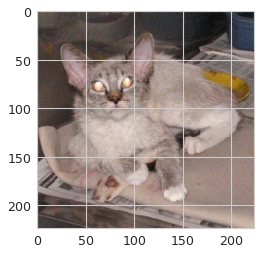

In [42]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [43]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [44]:
%time py = m(Variable(x.cuda()))

CPU times: user 169 ms, sys: 17.3 ms, total: 186 ms
Wall time: 7.76 ms


In [45]:
for o in sfs: o.remove()

In [46]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [47]:
py = np.exp(to_np(py)[0]); py # py就是预测

array([1., 0.], dtype=float32)

In [48]:
# feat从最后一层卷积层得到
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape
# {2,7,7}第一个通道指的是cat,第二个通道指的是Dog

(2, 7, 7)

In [49]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.2055 , 0.30138, 0.31727, 0.26016, 0.14828, 0.04365, 0.     ],
       [0.42763, 0.62315, 0.64106, 0.51127, 0.30528, 0.0992 , 0.     ],
       [0.6407 , 0.92026, 0.92345, 0.71728, 0.4297 , 0.15504, 0.     ],
       [0.71252, 1.     , 0.96818, 0.72489, 0.44625, 0.1865 , 0.02045],
       [0.60525, 0.84006, 0.79296, 0.58832, 0.36274, 0.15199, 0.01402],
       [0.37777, 0.50737, 0.47072, 0.35735, 0.23144, 0.10185, 0.01212],
       [0.16414, 0.21164, 0.19869, 0.15178, 0.09832, 0.03876, 0.00062]], dtype=float32)

/home/ubuntu/anaconda3/envs/fastai-0.7/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/fastai-0.7/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


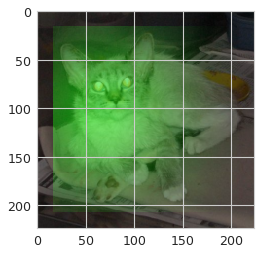

In [50]:
# 上面的f2就是最终的池化层之前的结果，将其resize成图像大小，并进行融合。就能重点突出目标所在区域。
plt.imshow(dx)
plt.imshow(skimage.transform.resize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [51]:
learn.unfreeze()
learn.bn_freeze(True)

In [52]:
# 12 layer groups call for 12 lrs
lr=np.array([[1e-6]*4,[1e-4]*4,[1e-2]*4]).flatten()

In [53]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.04792    0.065924   0.9875    
    1      0.033062   0.05042    0.987                        



[array([0.05042]), 0.987]

In [54]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.989

In [55]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.027027   0.039228   0.99      
    1      0.0239     0.046628   0.9895                       



[array([0.04663]), 0.9895]

In [56]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.9915